In [1]:
# Importing Dependencies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

**Data Cleansing**

In [2]:
df=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Jio_5g_data_import.xlsx')

In [3]:
df.head()

,Date,state,Data new,vendor,Band,KPI
0,2023-09-19,SH1,491104.0,Ericsson,N28,Total Traffic(GB)
1,2023-09-19,SH1,100969.0,Ericsson,N28,Connected Users
2,2023-09-19,SH1,16.0,Ericsson,N28,DL throughput
3,2023-09-20,SH1,473549.0,Ericsson,N28,Total Traffic
4,2023-09-20,SH1,100486.0,Ericsson,N28,Connected Users


In [4]:
# Pivot the data to get the required structure
# Corrected code
pivot_df = df.pivot_table(index=["Date", "state", "vendor"], columns=["KPI", "Band"], values="Data new").reset_index()

# Display the pivoted DataFrame
print(pivot_df.head())

KPI        Date state    vendor Connected Users           DL throughput  \
Band                                        N28       N78           N28   
0    2023-09-19   SH1  Ericsson        100969.0  366628.0          16.0   
1    2023-09-19  SH10  Ericsson         73469.0  321550.0          14.0   
2    2023-09-19  SH11  Ericsson        109310.0  282839.0          11.0   
3    2023-09-19  SH12  Ericsson         40516.0  123794.0          15.0   
4    2023-09-19  SH13  Ericsson         90043.0  469969.0          11.0   

KPI         Total Traffic            Total Traffic(GB)  
Band    N78           N28        N78               N28  
0     278.0           NaN  2821414.0          491104.0  
1     325.0      368126.0  1282868.0               NaN  
2     252.0      598001.0  2563191.0               NaN  
3     206.0      215914.0  1051639.0               NaN  
4     287.0      486587.0  2106650.0               NaN  


In [5]:
# Reset MultiIndex columns by flattening them into a single level
pivot_df.columns = ['_'.join(map(str, col)) if isinstance(col, tuple) else col for col in pivot_df.columns]

In [6]:
# Calculate Throughput, Connected Users, and Total Traffic
pivot_df['Throughput'] = pivot_df['DL throughput_N28'] + pivot_df['DL throughput_N78']
pivot_df['Connected Users'] = pivot_df['Connected Users_N28'] + pivot_df['Connected Users_N78']
pivot_df['Total Traffic'] = pivot_df['Total Traffic_N28'] + pivot_df['Total Traffic_N78']


In [7]:

# Drop the original DL throughput, Connected Users, and Total Traffic columns
columns_to_drop = [
    'DL throughput_N28', 'DL throughput_N78',
    'Connected Users_N28', 'Connected Users_N78',
    'Total Traffic_N28', 'Total Traffic_N78'
]
pivot_df.drop(columns=columns_to_drop, inplace=True)

# Group by Date to get the sum of Connected Users and Total Traffic, and mean of Throughput
aggregated_df = pivot_df.groupby('Date_').agg(
    Total_Connected_Users=('Connected Users', 'sum'),
    Total_Traffic_GB=('Total Traffic', 'sum'),
    Mean_Throughput=('Throughput', 'mean')
).reset_index()


In [8]:
aggregated_df.head()

,Date_,Total_Connected_Users,Total_Traffic_GB,Mean_Throughput
0,2023-09-19,4133917.0,24909098.0,298.470588
1,2023-09-20,6949952.0,43387226.0,217.500000
2,2023-09-21,6984001.0,43900456.0,218.500000
3,2023-09-22,7014856.0,43313815.0,216.678571
4,2023-09-23,7307597.0,45496817.0,216.571429


In [9]:
# Removing the first row as soem data is missing
Jio_5G = aggregated_df.drop(index=0)

# Setting 'Date' as the index
Jio_5G.set_index("Date_", inplace=True)

# Renaming the columns
Jio_5G.rename(columns={
    "Total_Connected_Users": "RRC_Connected_Users",
    "Mean_Throughput": "Throughput"
}, inplace=True)

# Renaming the index name
Jio_5G.index.name = "Date"

# Displaying the modified DataFrame
Jio_5G

,RRC_Connected_Users,Total_Traffic_GB,Throughput
Date,,,
2023-09-20,6949952.0,43387226.0,217.500000
2023-09-21,6984001.0,43900456.0,218.500000
2023-09-22,7014856.0,43313815.0,216.678571
2023-09-23,7307597.0,45496817.0,216.571429
2023-09-24,7276350.0,51147876.0,209.642857
...,...,...,...
2024-10-13,23240199.0,166904175.0,113.071429
2024-10-14,23648818.0,158859933.0,104.214286
2024-10-15,23914090.0,149413959.0,102.714286


**Visualize the Data**

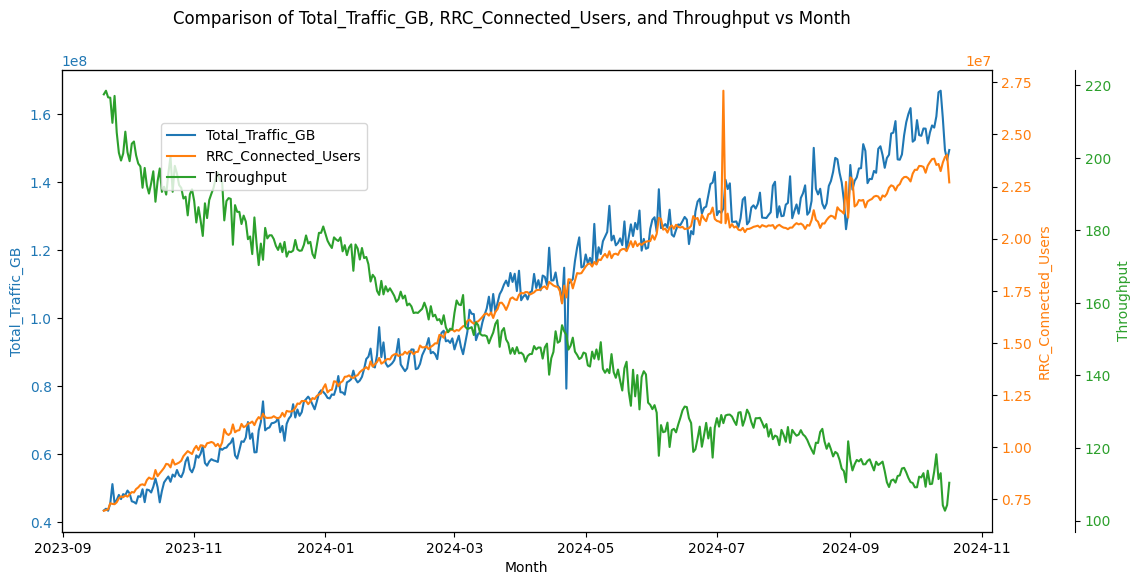

In [10]:

# Plot each series on the same graph with different y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Total_Traffic_GB vs Month
ax1.set_xlabel('Month')
ax1.set_ylabel('Total_Traffic_GB', color='tab:blue')
ax1.plot(Jio_5G.index, Jio_5G['Total_Traffic_GB'], color='tab:blue', label='Total_Traffic_GB')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for RRC_Connected_Users vs Month
ax2 = ax1.twinx()
ax2.set_ylabel('RRC_Connected_Users', color='tab:orange')
ax2.plot(Jio_5G.index, Jio_5G['RRC_Connected_Users'], color='tab:orange', label='RRC_Connected_Users')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Create a third y-axis for Throughput vs Month using twinx with an offset
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis to avoid overlap
ax3.set_ylabel('Throughput', color='tab:green')
ax3.plot(Jio_5G.index, Jio_5G['Throughput'], color='tab:green', label='Throughput')
ax3.tick_params(axis='y', labelcolor='tab:green')

# Adding titles and legends
fig.suptitle('Comparison of Total_Traffic_GB, RRC_Connected_Users, and Throughput vs Month')
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

plt.show()

3 Month Prediction of RRC_Connected_Users, Total_Traffic_GB	and Throughput

In [11]:
Jio_5G

,RRC_Connected_Users,Total_Traffic_GB,Throughput
Date,,,
2023-09-20,6949952.0,43387226.0,217.500000
2023-09-21,6984001.0,43900456.0,218.500000
2023-09-22,7014856.0,43313815.0,216.678571
2023-09-23,7307597.0,45496817.0,216.571429
2023-09-24,7276350.0,51147876.0,209.642857
...,...,...,...
2024-10-13,23240199.0,166904175.0,113.071429
2024-10-14,23648818.0,158859933.0,104.214286
2024-10-15,23914090.0,149413959.0,102.714286


<Axes: xlabel='Date'>

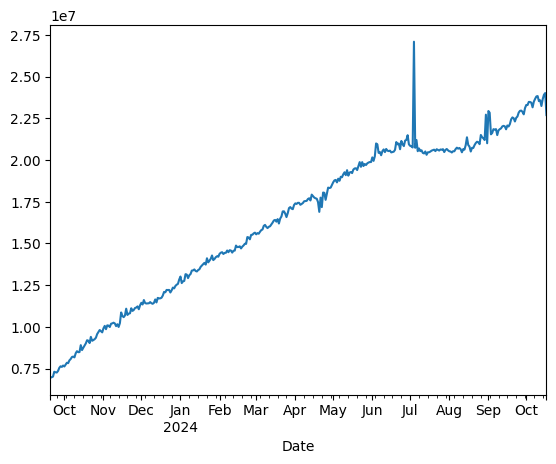

In [12]:
Jio_5G['RRC_Connected_Users'].plot()
# Jio_5G['Total_Traffic_GB'].plot()
# Jio_5G['Throughput'].plot()

In [13]:
test_result=adfuller(Jio_5G['RRC_Connected_Users'])
test_result=adfuller(Jio_5G['Total_Traffic_GB'])
test_result=adfuller(Jio_5G['Throughput'])

In [14]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(parameter):
    result=adfuller(parameter)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [15]:
adfuller_test(Jio_5G['RRC_Connected_Users'])
adfuller_test(Jio_5G['Total_Traffic_GB'])
adfuller_test(Jio_5G['Throughput'])

ADF Test Statistic : -2.0706380050820177
p-value : 0.25648389315272735
#Lags Used : 6
Number of Observations Used : 387
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
ADF Test Statistic : -1.0441420869713964
p-value : 0.7368261214994622
#Lags Used : 15
Number of Observations Used : 378
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
ADF Test Statistic : -1.5330712901272454
p-value : 0.5170926591017473
#Lags Used : 8
Number of Observations Used : 385
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


**Differencing**

In [16]:
#  Differencing to make data stationary
#  Weekly seasonality for daily data

Jio_5G['Difference_RRC_Connected_Users']=Jio_5G['RRC_Connected_Users']-Jio_5G['RRC_Connected_Users'].shift(7)
Jio_5G['Difference_Total_Traffic_GB']=Jio_5G['Total_Traffic_GB']-Jio_5G['Total_Traffic_GB'].shift(7)
Jio_5G['Difference_Throughput']=Jio_5G['Throughput']-Jio_5G['Throughput'].shift(7)


In [17]:
Jio_5G.head(10)

,RRC_Connected_Users,Total_Traffic_GB,Throughput,Difference_RRC_Connected_Users,Difference_Total_Traffic_GB,Difference_Throughput
Date,,,,,,
2023-09-20,6949952.0,43387226.0,217.500000,NaN,NaN,NaN
2023-09-21,6984001.0,43900456.0,218.500000,NaN,NaN,NaN
2023-09-22,7014856.0,43313815.0,216.678571,NaN,NaN,NaN
2023-09-23,7307597.0,45496817.0,216.571429,NaN,NaN,NaN
2023-09-24,7276350.0,51147876.0,209.642857,NaN,NaN,NaN
2023-09-25,7261664.0,45530856.0,217.071429,NaN,NaN,NaN
2023-09-26,7355782.0,46460515.0,207.000000,NaN,NaN,NaN
2023-09-27,7542314.0,47965339.0,201.392857,592362.0,4578113.0,-16.107143
2023-09-28,7634499.0,46740410.0,199.250000,650498.0,2839954.0,-19.250000


In [18]:
## Again test dickey fuller test
adfuller_test(Jio_5G['Difference_RRC_Connected_Users'].dropna())
adfuller_test(Jio_5G['Difference_Total_Traffic_GB'].dropna())
adfuller_test(Jio_5G['Difference_Throughput'].dropna())

ADF Test Statistic : -5.607856042104573
p-value : 1.222539471101354e-06
#Lags Used : 13
Number of Observations Used : 373
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
ADF Test Statistic : -5.803431892842943
p-value : 4.574463882969669e-07
#Lags Used : 14
Number of Observations Used : 372
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
ADF Test Statistic : -5.1613233174046265
p-value : 1.0539619598342138e-05
#Lags Used : 14
Number of Observations Used : 372
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Date'>

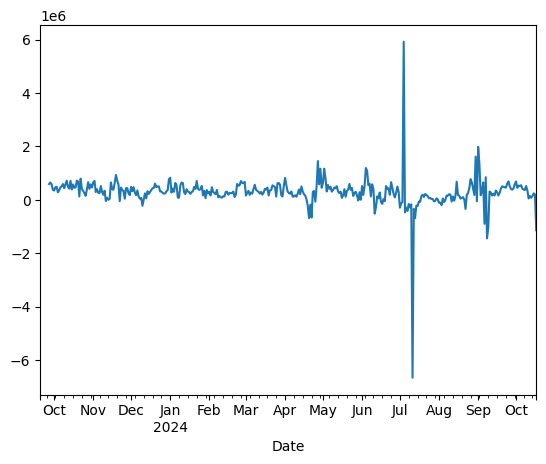

In [19]:
Jio_5G['Difference_RRC_Connected_Users'].plot()
# Jio_5G['Difference_Total_Traffic_GB'].plot()
# Jio_5G['Difference_Throughput'].plot()

**Auto Regressive Model**

In [20]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


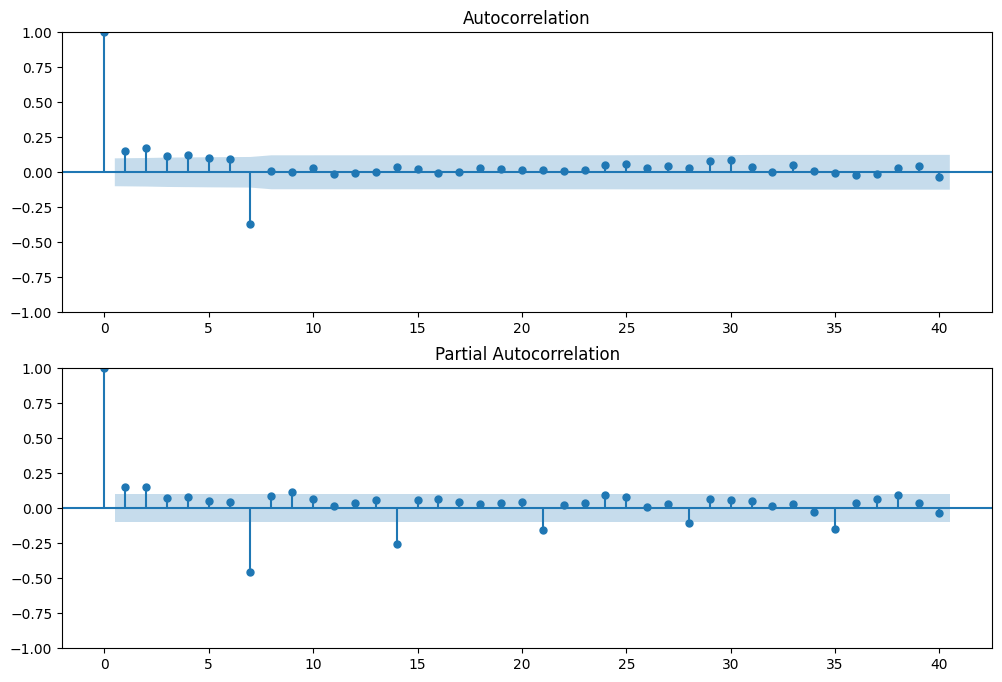

In [21]:
# Calculating acf and pacf for Difference_RRC_Connected_Users
# Identification of an MA model is often best done with the ACF(q)
# Identification of an AR model is often best done with the PACF(p)
# d in an ARIMA model represents the number of differencing steps required to make the series stationary(d)


fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Jio_5G['Difference_RRC_Connected_Users'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Jio_5G['Difference_RRC_Connected_Users'].dropna(),lags=40,ax=ax2)

# Therefore p=1 q=1 d=1

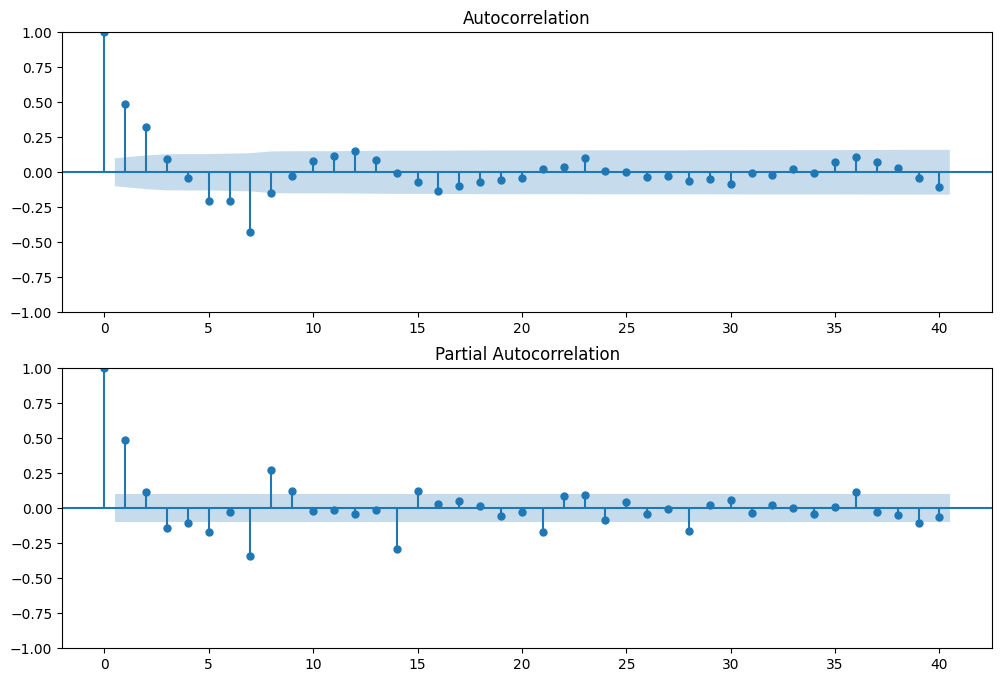

In [22]:
# Calculating acf and pacf for Difference_Total_Traffic_GB
# Identification of an MA model is often best done with the ACF(q)
# Identification of an AR model is often best done with the PACF(p)
# d in an ARIMA model represents the number of differencing steps required to make the series stationary(d)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Jio_5G['Difference_Total_Traffic_GB'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Jio_5G['Difference_Total_Traffic_GB'].dropna(),lags=40,ax=ax2)

# Therefore p=2 q=4 d=1

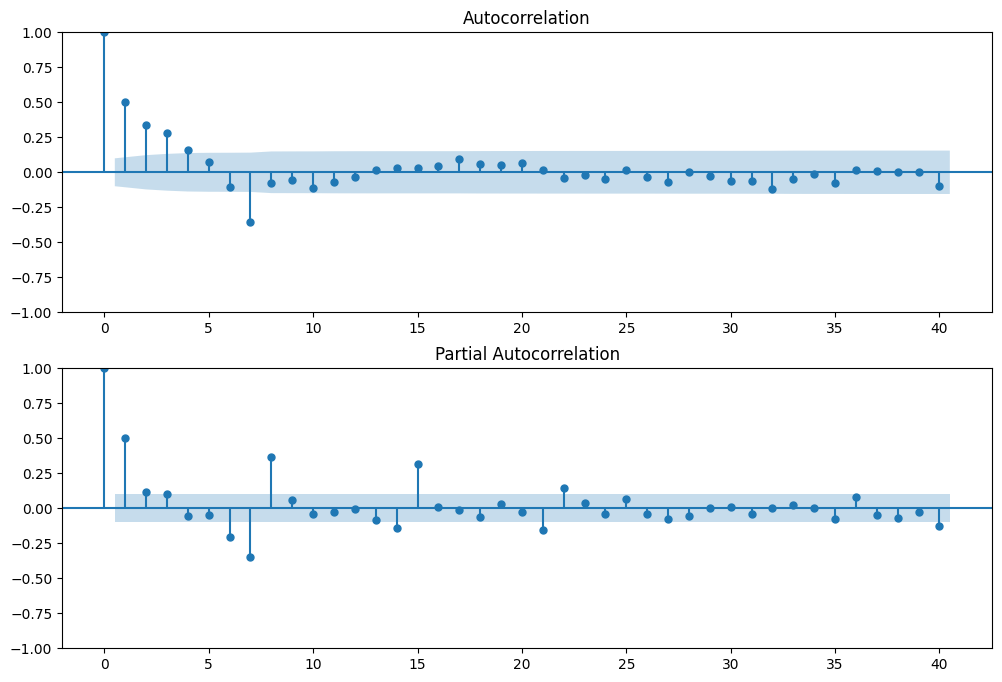

In [23]:
# Calculating acf and pacf for Difference_Throughput
# Identification of an MA model is often best done with the ACF(q)
# Identification of an AR model is often best done with the PACF(p)
# d in an ARIMA model represents the number of differencing steps required to make the series stationary(d)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Jio_5G['Difference_Throughput'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Jio_5G['Difference_Throughput'].dropna(),lags=40,ax=ax2)

# Therefore p=2 q=5 d=1

**Forecasting RRC_Connected_Users**

In [24]:
# Therefore p=1 q=1 d=1
model=sm.tsa.statespace.SARIMAX(Jio_5G['RRC_Connected_Users'],order=(1, 1, 1),seasonal_order=(1,1,1,7))
results=model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Date'>

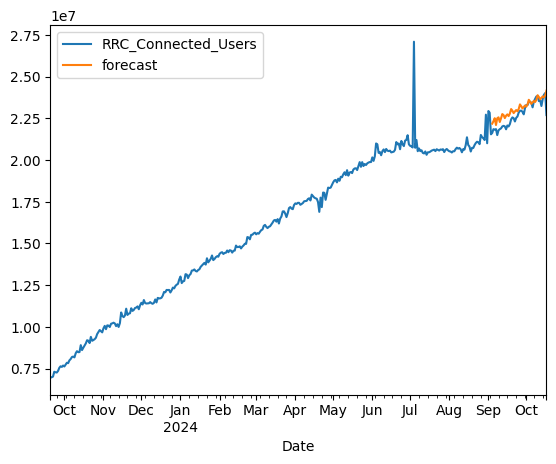

In [25]:
Jio_5G['forecast']=results.predict(start=350,end=400,dynamic=True)
Jio_5G[['RRC_Connected_Users','forecast']].plot()

In [26]:
from pandas.tseries.offsets import DateOffset
future_dates=[Jio_5G.index[-1] + DateOffset(days=x)for x in range(0,90)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_datest_df.tail()

,Date,state,Data new,vendor,Band,KPI
2025-01-10,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-11,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-12,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-13,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-14,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
future_df=pd.concat([Jio_5G,future_datest_df])

<Axes: >

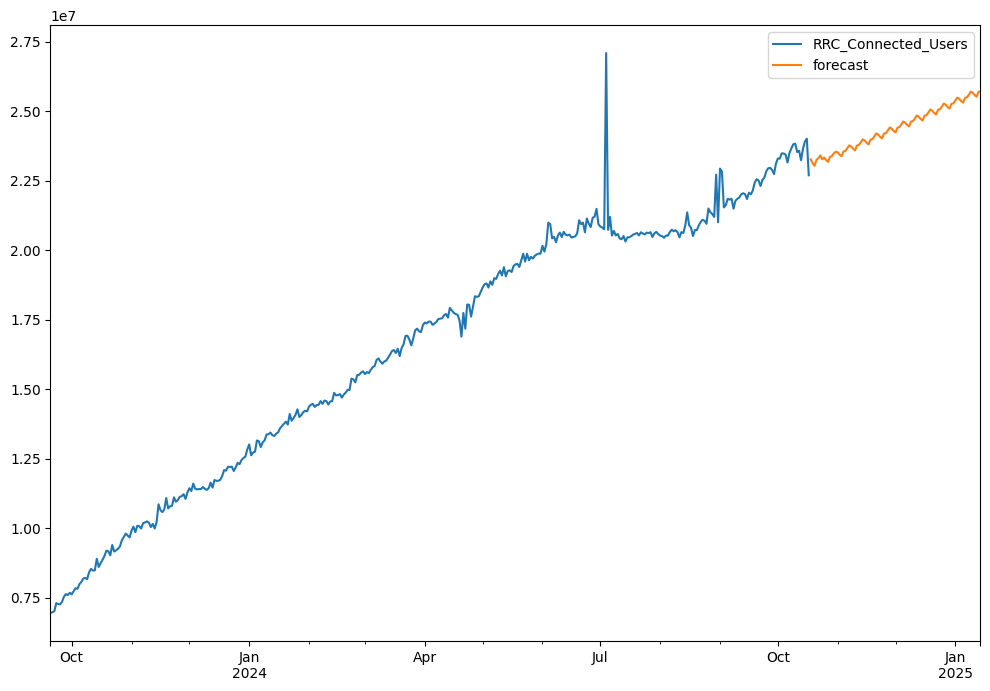

In [ ]:
future_df['forecast'] = results.predict(start = 394, end = 485, dynamic= True)
future_df[['RRC_Connected_Users', 'forecast']].plot(figsize=(12, 8))

**Forecasting Total_Traffic_GB**

In [28]:
# Therefore p=2 q=4 d=1
model=sm.tsa.statespace.SARIMAX(Jio_5G['Total_Traffic_GB'],order=(2, 1, 4),seasonal_order=(2,1,4,7),initialization='approximate_diffuse')
results=model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Date'>

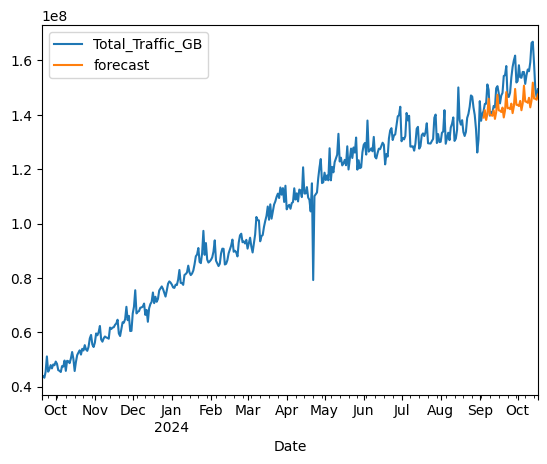

In [ ]:
Jio_5G['forecast']=results.predict(start=350,end=400,dynamic=True)
Jio_5G[['Total_Traffic_GB','forecast']].plot()

<Axes: >

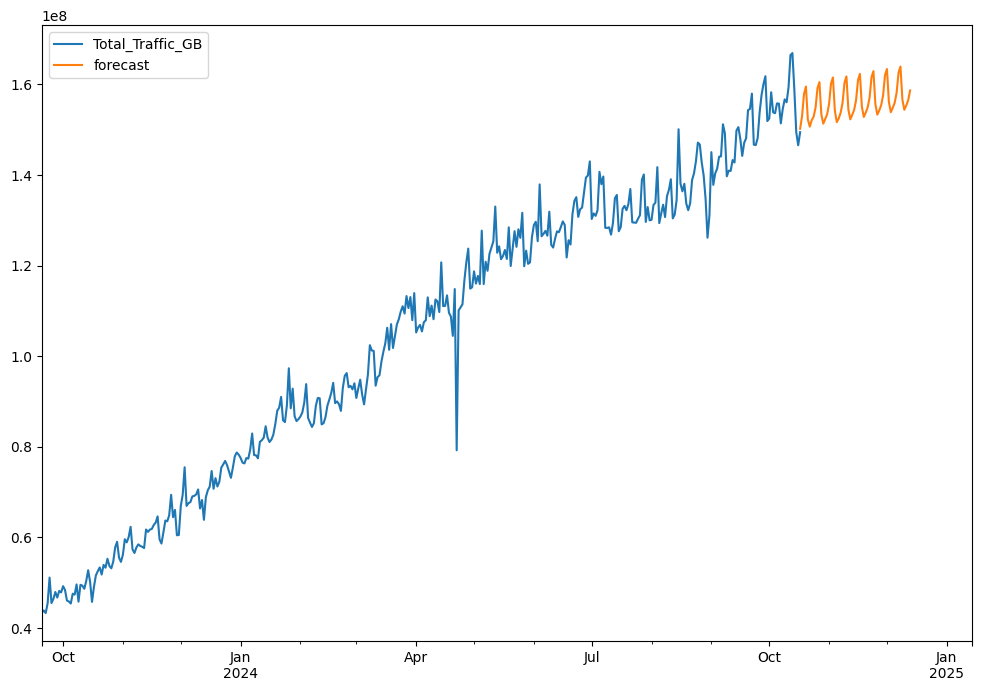

In [29]:
future_df['forecast'] = results.predict(start = 393, end = 450, dynamic= True)
future_df[['Total_Traffic_GB', 'forecast']].plot(figsize=(12, 8))

Forecasting Throughput

In [30]:
# Throughput
# p=2 q=5 d=1
model=sm.tsa.statespace.SARIMAX(Jio_5G['Throughput'],order=(2, 1, 5),seasonal_order=(2,1,5,7),initialization='approximate_diffuse')
results=model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Date'>

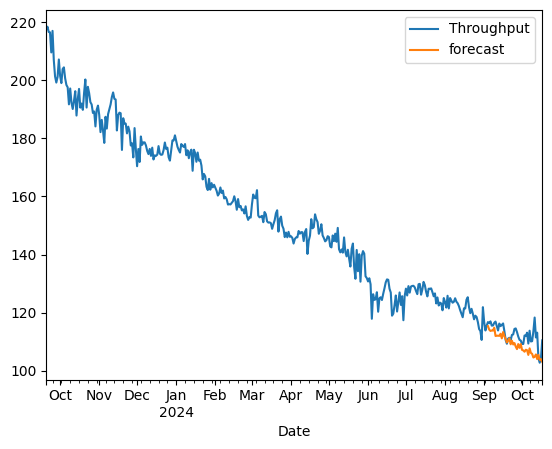

In [31]:
Jio_5G['forecast']=results.predict(start=350,end=400,dynamic=True)
Jio_5G[['Throughput', 'forecast']].plot()

<Axes: >

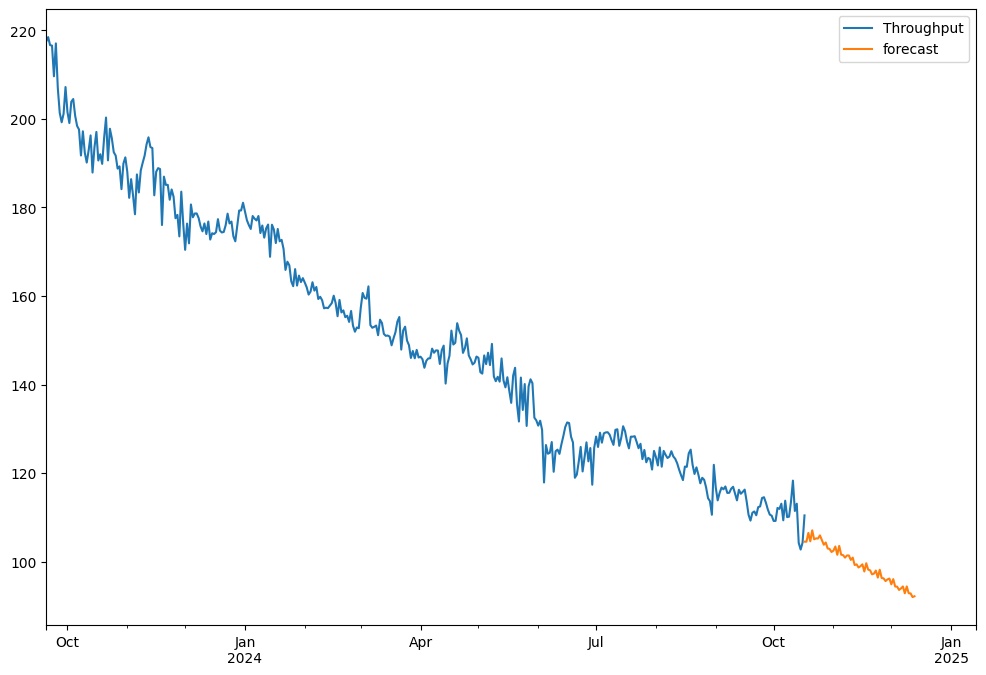

In [32]:
future_df['forecast'] = results.predict(start = 393, end = 450, dynamic= True)
future_df[['Throughput', 'forecast']].plot(figsize=(12, 8))